In [ ]:
from os import system

import geopandas as gpd
import pandas as pd
from contextily import add_basemap
from shapely import buffer
from shapely.geometry import box

In [3]:
# Load indonesia level 2 admin
admin = gpd.read_parquet("gs://gee-ramiqcom-bucket/admin/indonesia_adm_level_2.parquet")
admin

,WADMKK,WADMPR,geometry
0,Yahukimo,Papua Pegunungan,"MULTIPOLYGON Z (((139.99472 -4.4858 0, 139.994..."
1,Lombok Tengah,Nusa Tenggara Barat,"MULTIPOLYGON Z (((116.1878 -8.9146 0, 116.1879..."
2,Ende,Nusa Tenggara Timur,"MULTIPOLYGON Z (((121.53453 -8.89094 0, 121.53..."
3,Bone Bolango,Gorontalo,"MULTIPOLYGON Z (((123.19123 0.39365 0, 123.191..."
4,Murung Raya,Kalimantan Tengah,"MULTIPOLYGON Z (((114.39226 -0.83654 0, 114.39..."
...,...,...,...
512,Konawe Selatan,Sulawesi Tenggara,"MULTIPOLYGON Z (((122.21858 -4.48841 0, 122.21..."
513,Boyolali,Jawa Tengah,"MULTIPOLYGON Z (((110.54365 -7.62566 0, 110.54..."
514,Mimika,Papua Tengah,"MULTIPOLYGON Z (((136.45054 -4.735 0, 136.4504..."
515,Kota Banjarbaru,Kalimantan Selatan,"MULTIPOLYGON Z (((114.83477 -3.55076 0, 114.83..."


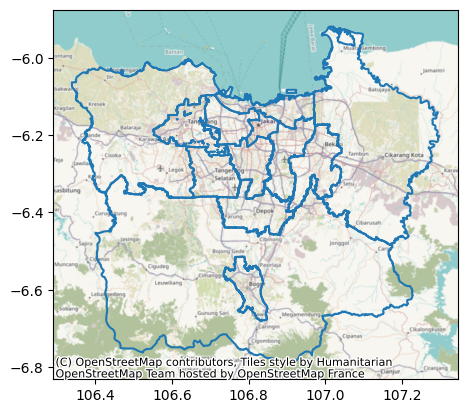

In [6]:
# Select jakarta, depok, bekasi, tangerang, bogor
jabodetabek = admin[
    (admin["WADMKK"].str.contains("Jakarta"))
    | (admin["WADMKK"].str.contains("Depok"))
    | (admin["WADMKK"].str.contains("Bekasi"))
    | (admin["WADMKK"].str.contains("Tangerang"))
    | (admin["WADMKK"].str.contains("Bogor"))
]
ax = jabodetabek.boundary.plot()
add_basemap(ax=ax, crs="EPSG:4326")

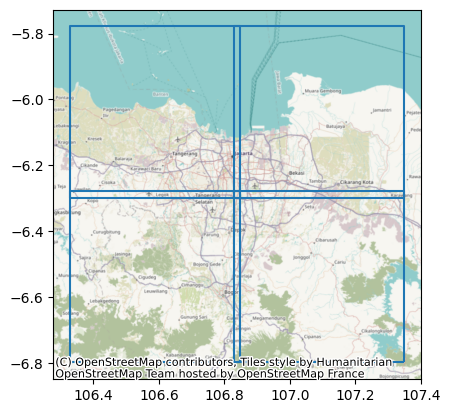

In [16]:
# Create bounding box and grids based on region
bounds = tuple(jabodetabek.total_bounds)
min_x = bounds[0]
max_x = bounds[2]
min_y = bounds[1]
max_y = bounds[3]
interval = 0.5
x_counts = round(abs(max_x - min_x) / interval)
y_counts = round(abs(max_y - min_y) / interval)

# Grids
grids = []

for x in range(x_counts):
    west = min_x + x * interval
    east = west + interval

    for y in range(y_counts):
        south = min_y + y * interval
        north = south + interval

        # Bounding box
        bbox = (west, south, east, north)

        # Polygon
        polygon = box(*bbox)

        # Buffer it by 0.1 degree
        polygon = buffer(polygon, 0.01)
        polygon = box(*polygon.bounds)

        # Grid id
        grid_id = f"{(y + 1):02d}Y_{(x + 1):02d}X"

        # Dictionary of the data
        grid = gpd.GeoDataFrame(
            [
                dict(
                    grid_id=grid_id,
                    min_x=west,
                    max_x=east,
                    min_y=south,
                    max_y=north,
                    x_id=x + 1,
                    y_id=y + 1,
                )
            ],
            geometry=[polygon],
            crs="EPSG:4326",
        )

        grids.append(grid)

# Grids ad geodataframe
grids = pd.concat(grids)
ax = grids.boundary.plot()
add_basemap(ax, crs="EPSG:4326")

In [26]:
# Save the grids
grid_name = "jabodetabek_grids"
grids.to_parquet(f"{grid_name}.parquet", write_covering_bbox=True)
grids.to_file(f"{grid_name}.geojson")

# Authenticate with google cloud
system("gcloud auth activate-service-account --key-file=private_key.json")

# Save it to cloud storage
system(
    f"gcloud storage cp {grid_name}.parquet gs://gee-ramiqcom-bucket/flood_map/roi/{grid_name}.parquet"
)
system(
    f"gcloud storage cp {grid_name}.geojson gs://gee-ramiqcom-bucket/flood_map/roi/{grid_name}.geojson"
)

0